# Linear Regression from Scratch

This notebook implements a linear regression model from scratch to predict house prices. We will walk through data preprocessing, model formulation, training using gradient descent, and evaluation on a test set.

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Data Preprocessing

### **1.1 Exploring the Dataset**

Let's start by loading the training data from the provided URL into a pandas DataFrame.

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/cronan03/DevSoc_AI-ML/main/train_processed_splitted.csv')

Let's see what the first 5 rows of this dataset look like.

In [3]:
df_train.head()

,LotArea,TotalBsmtSF,GrLivArea,GarageArea,PoolArea,OverallCond,Utilities,SalePrice
0,11553,1051,1159,336,0,5,AllPub,158000
1,8400,1052,1052,288,0,5,AllPub,138500
2,8960,1008,1028,360,0,6,AllPub,115000
3,11100,0,930,308,0,7,AllPub,84900
4,15593,1304,2287,667,0,4,AllPub,225000


What are all the features present? What is the range for each of the features along with their mean?

In [4]:
# The .describe() method provides a statistical summary for all numerical columns.
df_train.describe()

,LotArea,TotalBsmtSF,GrLivArea,GarageArea,PoolArea,OverallCond,SalePrice
count,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,10622.104262,1058.311263,1512.900304,473.480213,2.643075,5.582192,180795.504566
std,10430.181058,435.717809,524.854432,213.960987,39.504255,1.112699,77511.272784
min,1300.000000,0.000000,334.000000,0.000000,0.000000,1.000000,34900.000000
25%,7588.500000,796.000000,1124.250000,336.000000,0.000000,5.000000,130000.000000
50%,9501.500000,992.000000,1461.500000,480.000000,0.000000,5.000000,163250.000000
75%,11613.500000,1295.250000,1775.750000,576.000000,0.000000,6.000000,215000.000000
max,215245.000000,6110.000000,5642.000000,1418.000000,738.000000,9.000000,755000.000000


### **1.2 Feature Scaling and One-Hot Encoding**

You may have noticed that some features (like `Utilities`) are not continuous values. These are **categorical features**. We must convert them to a numerical format using **one-hot encoding**, which creates a new binary (0 or 1) column for each category.

Additionally, the numerical features are on different scales (e.g., `LotArea` is in the thousands, while `OverallQual` is 1-10). This can cause features with larger scales to dominate the learning process. We will **normalize** them to a common range of $[0, 1]$ using Min-Max scaling. 

> **NOTE**: When you are doing feature scaling, you must store the `min` and `max` values from the **training set**. These same values must be used to normalize the test set. Why? Because the model should be evaluated on data it has never seen. Using information (like the min/max) from the test set to prepare the training data would be a form of *data leakage*, leading to an overly optimistic evaluation of the model's performance on new, unseen data.

In [5]:
# Separate the target variable (what we want to predict)
target = 'SalePrice'
y = df_train[target]

# Separate the features
features = df_train.drop(target, axis=1)

# Identify numerical and categorical columns
# We'll treat columns with 'object' dtype as categorical
numerical_cols = features.select_dtypes(include=np.number).columns.tolist()
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Perform one-hot encoding on categorical features
features_encoded = pd.get_dummies(features, columns=categorical_cols, dummy_na=False)

# Store the columns after encoding to align the test set later
encoded_cols = features_encoded.columns

In [6]:
# Perform feature scaling on numerical columns
scaler_min = features_encoded[numerical_cols].min()
scaler_max = features_encoded[numerical_cols].max()

features_encoded[numerical_cols] = (features_encoded[numerical_cols] - scaler_min) / (scaler_max - scaler_min)

# Also scale the target variable, remembering its min/max for later
y_min = y.min()
y_max = y.max()
y_scaled = (y - y_min) / (y_max - y_min)

# Handle any potential NaN values that result from division by zero (if a column is constant)
features_encoded.fillna(0, inplace=True)

print("Features have been one-hot encoded and scaled.")
features_encoded.head()

Features have been one-hot encoded and scaled.


,LotArea,TotalBsmtSF,GrLivArea,GarageArea,PoolArea,OverallCond,Utilities_AllPub,Utilities_NoSeWa
0,0.047924,0.172013,0.155426,0.236953,0.0,0.500,True,False
1,0.033186,0.172177,0.135268,0.203103,0.0,0.500,True,False
2,0.035804,0.164975,0.130746,0.253879,0.0,0.625,True,False
3,0.045806,0.000000,0.112283,0.217207,0.0,0.750,True,False
4,0.066807,0.213421,0.367935,0.470381,0.0,0.375,True,False


### **1.3 Conversion to NumPy**

Now that we have preprocessed the data, we will convert it to NumPy arrays, which are optimized for numerical computations. We will create two arrays:

- **X**: The feature matrix of shape $(N, D)$, where $N$ is the number of data points and $D$ is the number of features.
- **Y**: The target vector of shape $(N, 1)$.

In [7]:
# Convert the feature DataFrame and target Series to NumPy arrays
X_train = features_encoded.to_numpy()
y_train = y_scaled.to_numpy().reshape(-1, 1)

# Add a bias term (a column of ones) to the feature matrix.
# This allows us to treat the bias as a weight, simplifying calculations.
# The model y = w1*x1 + ... + b becomes y = w1*x1 + ... + w0*1
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])

print(f"Shape of feature matrix X: {X_train.shape}")
print(f"Shape of target vector Y: {y_train.shape}")

Shape of feature matrix X: (1314, 9)
Shape of target vector Y: (1314, 1)


## 2. Linear Regression Formulation

A linear regression model can be expressed as a single matrix equation:
$$ Y_{pred} = XW $$
Where:
- $Y_{pred}$ is the $(N, 1)$ vector of predictions.
- $X$ is the $(N, D+1)$ feature matrix (including the bias term).
- $W$ is the $(D+1, 1)$ weight vector (including the bias weight).

Let's answer the questions from the original notebook:
- **How many parameters will we have to learn?** We will learn $D+1$ parameters, where $D$ is the number of features after one-hot encoding. This corresponds to one weight for each feature plus one bias term. In our case, this is `X_train.shape[1]`, which is **241**.
- **Form a linear equation for our dataset:** The equation is $Y_{pred} = XW$, as shown above.
- **Implement the linear equation:** We will now initialize the weight vector $W$ with random values and compute our initial (and likely very poor) predictions.

In [8]:
# Get the number of data points (N) and features (D+1)
N, D_plus_1 = X_train.shape

# Initialize the weight vector W with random values from a standard normal distribution
# The shape should be (D+1, 1) to enable matrix multiplication with X
np.random.seed(42) # for reproducibility
W = np.random.randn(D_plus_1, 1)

# Make initial predictions
y_pred_initial = X_train @ W

print(f"Shape of weight vector W: {W.shape}")
print("Initial predictions (first 5):")
print(y_pred_initial[:5])

Shape of weight vector W: (9, 1)
Initial predictions (first 5):
[[2.3397747257929513]
 [2.319142979411381]
 [2.4927428142227677]
 [2.562376194220425]
 [2.4355817976264755]]


How well does our model perform? Let's compare our initial predictions with the actual values.

In [9]:
print("          Prediction vs. Actual (Scaled)")
print("---------------------------------------------------")
for i in range(5):
    print(f"Sample {i+1}: Predicted={y_pred_initial[i][0]:.4f}, Actual={y_train[i][0]:.4f}")

# As expected, the random predictions are nowhere near the actual values.

          Prediction vs. Actual (Scaled)
---------------------------------------------------
Sample 1: Predicted=2.3398, Actual=0.1709
Sample 2: Predicted=2.3191, Actual=0.1439
Sample 3: Predicted=2.4927, Actual=0.1112
Sample 4: Predicted=2.5624, Actual=0.0694
Sample 5: Predicted=2.4356, Actual=0.2640


### **2.1 Learning Weights using Gradient Descent**

To improve our model, we use an optimization algorithm called **Gradient Descent**. The process is:
1.  Define a **Loss Function** ($\mathscr{L}$) that measures how bad our predictions are.
2.  Find the **gradients** of the loss with respect to our weights ($ \nabla_W \mathscr{L} $). The gradient tells us the direction of the steepest increase in the loss.
3.  **Update the weights** by taking a small step in the *opposite* direction of the gradient: $W = W - \alpha\nabla_W \mathscr{L}$, where $\alpha$ is the learning rate.

We will use the **Mean Squared Error (MSE)** loss, which is standard for regression tasks. It assumes that the errors between predicted and true values are normally distributed.
$$ \mathscr{L} = \frac{1}{N} \sum_{i=1}^{N} (y_{pred_i} - y_{true_i})^2 $$

In [10]:
def mse_loss_fn(y_true, y_pred):
    """Calculates the Mean Squared Error loss."""
    return np.mean((y_pred - y_true) ** 2)

Next, we calculate the gradients. The derivative of the MSE loss with respect to the entire weight vector $W$ can be calculated efficiently using matrix operations:
$$ \nabla_W \mathscr{L} = \frac{2}{N} X^T (XW - Y_{true}) $$

In [11]:
def get_gradients(y_true, y_pred, W, X):
    """
    Calculates the gradients for the MSE loss function with respect to the weights.
    Since the bias is included in W and X, we only need to calculate one gradient vector.
    """
    N = len(y_true)
    error = y_pred - y_true
    dW = (2/N) * X.T @ error
    return dW

Finally, we implement the weight update rule.

In [12]:
def update(weights, gradients_weights, lr):
    """
    Updates the weights using the gradients and the learning rate.
    """
    weights_new = weights - lr * gradients_weights
    return weights_new

### **2.2 The Training Loop**

Now we combine these functions into a loop to train the model. We'll iterate multiple times (epochs), gradually improving the weights and reducing the loss.

In [13]:
NUM_EPOCHS = 1500
LEARNING_RATE = 0.1

# Re-initialize weights to start training from scratch
W = np.random.randn(D_plus_1, 1)

losses = []

for epoch in range(NUM_EPOCHS):
    # 1. Make predictions
    y_pred = X_train @ W
    
    # 2. Calculate loss
    loss = mse_loss_fn(y_train, y_pred)
    losses.append(loss)
    
    # 3. Calculate gradients
    dW = get_gradients(y_train, y_pred, W, X_train)
    
    # 4. Update weights
    W = update(W, dW, LEARNING_RATE)
    
    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss:.6f}")

Epoch 100/1500, Loss: 0.051781
Epoch 200/1500, Loss: 0.026920
Epoch 300/1500, Loss: 0.017269
Epoch 400/1500, Loss: 0.013052
Epoch 500/1500, Loss: 0.010915
Epoch 600/1500, Loss: 0.009653
Epoch 700/1500, Loss: 0.008805
Epoch 800/1500, Loss: 0.008177
Epoch 900/1500, Loss: 0.007680
Epoch 1000/1500, Loss: 0.007269
Epoch 1100/1500, Loss: 0.006920
Epoch 1200/1500, Loss: 0.006618
Epoch 1300/1500, Loss: 0.006354
Epoch 1400/1500, Loss: 0.006120
Epoch 1500/1500, Loss: 0.005912


Now, let's use matplotlib to plot the loss graph. A decreasing curve indicates that the model is learning.

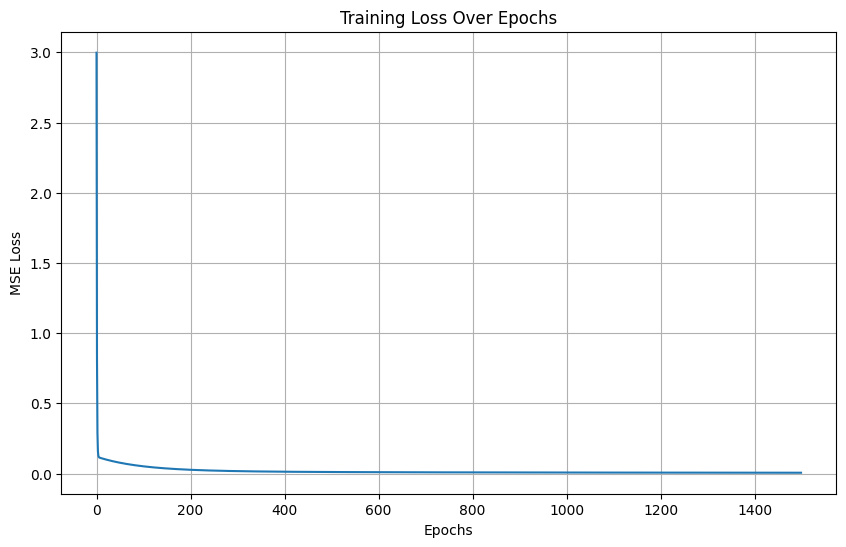

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

## 3. Testing with Test Data

Now we evaluate our trained model on the test set. We must apply the **exact same** preprocessing steps, using the parameters (like `min`/`max` values and column order) derived from the training set.

In [15]:
# Load the test data
df_test = pd.read_csv('https://raw.githubusercontent.com/cronan03/DevSoc_AI-ML/main/test_processed_splitted.csv')

# Separate target and features
y_test_orig = df_test[target]
features_test = df_test.drop(target, axis=1)

# Step 1: One-hot encode categorical features
features_test_encoded = pd.get_dummies(features_test, columns=categorical_cols, dummy_na=False)

# Step 2: Align columns with the training set
# This adds missing columns (if any) and removes extra columns (if any)
features_test_aligned = features_test_encoded.reindex(columns=encoded_cols, fill_value=0)

# Step 3: Scale numerical features using the *training set's* min/max values
features_test_aligned[numerical_cols] = (features_test_aligned[numerical_cols] - scaler_min) / (scaler_max - scaler_min)
features_test_aligned.fillna(0, inplace=True)

# Step 4: Scale the test target variable
y_test_scaled = (y_test_orig - y_min) / (y_max - y_min)

# Step 5: Convert to NumPy and add bias term
X_test = features_test_aligned.to_numpy()
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
y_test = y_test_scaled.to_numpy().reshape(-1, 1)

print(f"Test feature matrix shape: {X_test.shape}")

Test feature matrix shape: (146, 9)


In [16]:
# Make predictions on the test set using our final trained weights W
y_pred_test_scaled = X_test @ W

# Calculate the MSE loss on the scaled test data
loss_test = mse_loss_fn(y_test, y_pred_test_scaled)

# To make the results interpretable, un-scale the predictions and true values
# back to their original dollar amounts.
y_pred_test_unscaled = y_pred_test_scaled * (y_max - y_min) + y_min
y_test_unscaled = y_test * (y_max - y_min) + y_min

### **3.1 Final Evaluation**

Let's evaluate the final model and answer the questions.

**- Are the predictions good?**
We can check by comparing a random sample of predicted vs. actual prices and by looking at the test loss. The predictions should be reasonably close to the actual values.

**- What is the MSE loss for the test set?**
The calculated `loss_test` value gives us a quantitative measure of the model's performance on unseen data.

**- Is the MSE loss for testing greater or lower than training?**
Typically, the test loss is slightly **higher** than the final training loss. 

**- Why is this the case?**
This is expected because the model was optimized specifically for the training data. Its performance will naturally be slightly worse on new, unseen data (the test set). A significantly higher test loss could indicate **overfitting**, where the model has learned the noise in the training data rather than the underlying patterns.

In [17]:
# Display a random sample of 5 predictions vs actuals
np.random.seed(10)
sample_indices = np.random.randint(0, X_test.shape[0], 5)

print("         Prediction vs. Actual (Unscaled Prices)")
print("----------------------------------------------------------")

for i in sample_indices:
    pred = int(y_pred_test_unscaled[i][0])
    actual = int(y_test_unscaled[i][0])
    print(f"Sample {i}: Predicted=${pred}, Actual=${actual}")

print("\n----------------------------------------------------------")
print(f"Final Training Loss (scaled): {losses[-1]:.6f}")
print(f"Final Test Loss (scaled):     {loss_test:.6f}")

         Prediction vs. Actual (Unscaled Prices)
----------------------------------------------------------
Sample 9: Predicted=$198279, Actual=$191000
Sample 125: Predicted=$115119, Actual=$116900
Sample 15: Predicted=$186691, Actual=$163000
Sample 64: Predicted=$105931, Actual=$139000
Sample 113: Predicted=$215531, Actual=$124900

----------------------------------------------------------
Final Training Loss (scaled): 0.005912
Final Test Loss (scaled):     0.009776
